<a href="https://colab.research.google.com/github/Austfi/SNOWPACKforPatrollers/blob/dev/Snowprofile_Colab_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Snowprofile Tutorial: Read, Plot, and Analyze CAAML Files

This tutorial teaches you how to use the `snowprofile` Python package with CAAML v6 files. You'll learn to read snow profile data, explore the data structure, and create visualizations.

**What you'll do:**
1. Install the package
2. Load a CAAML file
3. Explore the data
4. Create plots
5. Analyze temperature profiles

**Example file**: This tutorial uses `snowprofiles/example_profile.caaml`. When running in Colab, it will automatically download from the repository.

**Documentation**: For more details, see the [official snowprofile documentation](https://snowprofile.readthedocs.io/en/latest/).



In [3]:
# Step 1: Setup environment
# This cell checks if you're running in Google Colab and sets up plotting

import sys

# Check if running in Colab
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    print("✓ Running in Google Colab")
else:
    print("⚠ Not running in Colab - some features may not work")

# Silence warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting (shows plots in notebook)
%matplotlib inline
print("✓ Setup complete")




⚠ Not running in Colab - some features may not work
✓ Setup complete


In [4]:
# Step 2: Install the snowprofile package
# Run this cell to install the package and dependencies

%pip install -q snowprofile pandas numpy matplotlib

# Verify installation
import snowprofile

# Check version
try:
    version = snowprofile.__version__
    print(f"✓ snowprofile version: {version}")
except AttributeError:
    try:
        import importlib.metadata
        version = importlib.metadata.version('snowprofile')
        print(f"✓ snowprofile version: {version}")
    except Exception:
        print("✓ snowprofile installed and ready to use")





Note: you may need to restart the kernel to use updated packages.
✓ snowprofile version: 0.1.1


In [5]:
# Step 3: Import required libraries
# This loads the tools we need for working with snow profiles

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import snowprofile functions
import snowprofile
from snowprofile import io as spio  # For reading/writing CAAML files
from snowprofile import plot as spplot  # For plotting

print("✓ All libraries imported successfully")




✓ All libraries imported successfully


In [6]:
# Step 4: Load your CAAML file
# This cell loads the example file. To use your own file, change CAAML_PATH below.

# Try to use the example file from the repository (if running locally)
EXAMPLE_FILE = Path("snowprofiles/example_profile.caaml")

if EXAMPLE_FILE.exists():
    CAAML_PATH = EXAMPLE_FILE
    print(f"✓ Using example file: {CAAML_PATH}")
elif IN_COLAB:
    # In Colab, check if file already exists first
    CAAML_PATH = Path("example_profile.caaml")
    
    if CAAML_PATH.exists():
        print(f"✓ Using existing file: {CAAML_PATH}")
    else:
        # Download example file from GitHub
        print("Downloading example CAAML file...")
        import urllib.request
        
        # Try dev branch first (where the file is), then main as fallback
        branches = ["dev", "main"]
        downloaded = False
        
        for branch in branches:
            try:
                example_url = f"https://raw.githubusercontent.com/Austfi/SNOWPACKforPatrollers/{branch}/snowprofiles/example_profile.caaml"
                urllib.request.urlretrieve(example_url, str(CAAML_PATH))
                print(f"✓ Downloaded from {branch} branch: {CAAML_PATH}")
                downloaded = True
                break
            except Exception as e:
                if branch == "main":
                    print(f"⚠ Could not download from {branch} branch")
                continue
        
        if not downloaded:
            # Fallback: file upload
            print("\n⚠ Could not download example file from GitHub.")
            print("Please upload your own CAAML file:")
            from google.colab import files
            uploaded = files.upload()
            CAAML_PATH = Path(next(iter(uploaded)))
            print(f"✓ Uploaded: {CAAML_PATH}")
else:
    # For your own file, change this path:
    CAAML_PATH = Path("your_file.caaml")  # ← Change this to your file path
    print(f"Using file: {CAAML_PATH}")

# Verify file exists
assert CAAML_PATH.exists(), f"File not found: {CAAML_PATH}"
print(f"✓ File ready: {CAAML_PATH}")








✓ Using example file: snowprofiles/example_profile.caaml
✓ File ready: snowprofiles/example_profile.caaml


## Step 5: Read the CAAML File

This reads your CAAML file and creates a SnowProfile object that contains all the data.

**About SnowProfile objects**: A `SnowProfile` object contains profiles that share the same location and time. It stores information like stratigraphy layers, temperature profiles, density profiles, and other snow property measurements.

**Units and conventions**:
- Heights are measured in meters (SI units)
- Zero is at the bottom of the profile
- The package handles unit conversions automatically when reading/writing CAAML files



In [7]:
# Read the CAAML file
# This creates a SnowProfile object called 'sp' that contains all your data

sp = spio.read_caaml6_xml(str(CAAML_PATH))
print(f"✓ Successfully loaded: {CAAML_PATH.name}")
print(f"✓ SnowProfile object created")

# The variable 'sp' now contains all your snow profile data
# You can use 'sp' in the cells below to explore and plot the data



✓ Successfully loaded: example_profile.caaml
✓ SnowProfile object created


## Step 6: Explore Your Snow Profile Data

The SnowProfile object (`sp`) contains information about:
- **Time**: When the profile was recorded
- **Location**: Where it was taken (name, elevation, coordinates)
- **Profile depth**: Total snow depth in meters
- **Stratigraphy**: Information about each snow layer
- **Profiles**: Temperature, density, hardness measurements at different depths



In [8]:
# View basic information about your snow profile

print("=" * 60)
print("SNOW PROFILE INFORMATION")
print("=" * 60)

# Time
if hasattr(sp, 'record_time') and sp.record_time:
    print(f"\nRecord time: {sp.record_time}")

# Location
if hasattr(sp, 'name') and sp.name:
    print(f"Location: {sp.name}")
if hasattr(sp, 'elevation') and sp.elevation is not None:
    print(f"Elevation: {sp.elevation} m")
if hasattr(sp, 'latitude') and sp.latitude is not None:
    print(f"Coordinates: {sp.latitude}°N, {sp.longitude}°W")

# Profile depth
if hasattr(sp, 'profile_depth') and sp.profile_depth is not None:
    print(f"\nProfile depth: {sp.profile_depth:.2f} m")
if hasattr(sp, 'profile_swe') and sp.profile_swe is not None:
    print(f"Snow Water Equivalent (SWE): {sp.profile_swe:.1f} mm")

# Available data types
print(f"\nAvailable data:")
print(f"  Temperature profiles: {len(sp.temperature_profiles) if sp.temperature_profiles else 0}")
print(f"  Density profiles: {len(sp.density_profiles) if sp.density_profiles else 0}")
print(f"  Stratigraphy layers: {len(sp.stratigraphy_profile.data) if sp.stratigraphy_profile and hasattr(sp.stratigraphy_profile, 'data') else 'not available'}")

print("=" * 60)



SNOW PROFILE INFORMATION

Profile depth: 1.83 m
Snow Water Equivalent (SWE): 504.3 mm

Available data:
  Temperature profiles: 1
  Density profiles: 1
  Stratigraphy layers: 17


In [9]:
# Look at the stratigraphy (snow layers)
# This shows each layer with its properties like thickness, grain type, and hardness

if sp.stratigraphy_profile is not None:
    # Get the data as a DataFrame (like a spreadsheet)
    df = sp.stratigraphy_profile.data
    print(f"Total layers: {len(df)}")
    print(f"\nFirst few layers:")
    print(df.head())
    
    # Show layer thicknesses
    if 'thickness' in df.columns:
        print(f"\nLayer thickness summary:")
        print(f"  Average: {df['thickness'].mean():.3f} m")
        print(f"  Thickest: {df['thickness'].max():.3f} m")
        print(f"  Thinnest: {df['thickness'].min():.3f} m")
else:
    print("No stratigraphy data available")




Total layers: 17

First few layers:
   top_height  thickness grain_1 grain_2  grain_size  grain_size_max hardness  \
0       1.830      0.003      DF      PP     0.00100          0.0015        F   
1       1.827      0.037      DF      RG     0.00025          0.0010        F   
2       1.790      0.080      DF    None     0.00050          0.0010        F   
3       1.710      0.360      DF      FC     0.00050          0.0010        F   
4       1.350      0.010      RG    None     0.00025          0.0005       4F   

  wetness comment  bottom_height  
0       D    None          1.827  
1       D    None          1.790  
2       D    None          1.710  
3       D    None          1.350  
4       D    None          1.340  

Layer thickness summary:
  Average: 0.108 m
  Thickest: 0.380 m
  Thinnest: 0.003 m


## Step 7: Analyze Temperature Profile

Temperature gradients show how quickly temperature changes with depth. Strong gradients (≥ 10 °C/m) can indicate rapid temperature changes or potential instability.

**Formula**: The gradient is calculated as change in temperature divided by change in depth: dT/dz ≈ (T₂ - T₁) / (z₂ - z₁)

**Units**: °C/m (degrees Celsius per meter)



Temperature profile analysis:
  Data points: 21
  Depth range: 0.00 - 1.83 m
  Temperature range: -18.50 - -0.20 °C
  Strong gradients (≥10 °C/m): 6 points


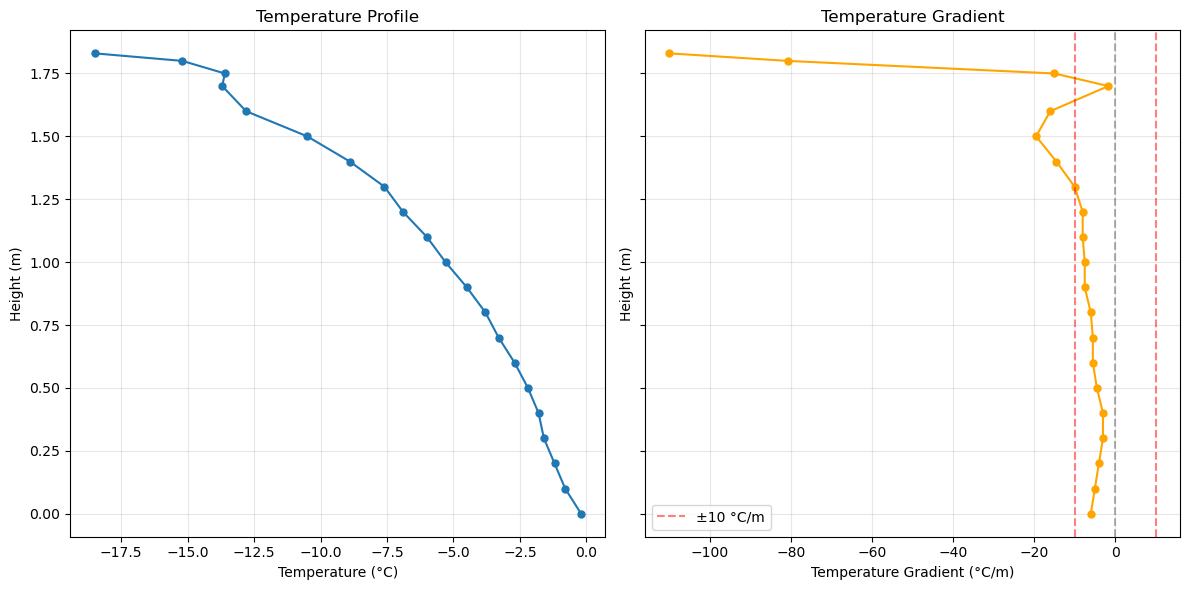

In [10]:
# Analyze temperature profile and calculate gradients
# Change temp_profiles[0] to temp_profiles[1] if you want to analyze a different temperature profile

if sp.temperature_profiles and len(sp.temperature_profiles) > 0:
    # Get the first temperature profile
    temp_profile = sp.temperature_profiles[0]  # ← Change index [0] to use a different profile
    
    # Get the data
    temp_data = temp_profile.data
    
    # Sort by height (depth)
    temp_data = temp_data.sort_values('height')
    heights = temp_data['height'].values
    temps = temp_data['temperature'].values
    
    # Calculate temperature gradient (how fast temperature changes with depth)
    dTdz = np.gradient(temps, heights)
    
    # Find strong gradients (≥ 10 °C/m)
    strong_gradients = np.abs(dTdz) >= 10
    
    print(f"Temperature profile analysis:")
    print(f"  Data points: {len(heights)}")
    print(f"  Depth range: {heights.min():.2f} - {heights.max():.2f} m")
    print(f"  Temperature range: {temps.min():.2f} - {temps.max():.2f} °C")
    print(f"  Strong gradients (≥10 °C/m): {np.sum(strong_gradients)} points")
    
    # Plot temperature and gradient
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Temperature profile
    ax1.plot(temps, heights, 'o-', markersize=5)
    ax1.set_xlabel('Temperature (°C)')
    ax1.set_ylabel('Height (m)')
    ax1.set_title('Temperature Profile')
    ax1.grid(True, alpha=0.3)
    
    # Temperature gradient
    ax2.plot(dTdz, heights, 'o-', markersize=5, color='orange')
    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax2.axvline(x=10, color='r', linestyle='--', alpha=0.5, label='±10 °C/m')
    ax2.axvline(x=-10, color='r', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Temperature Gradient (°C/m)')
    ax2.set_ylabel('Height (m)')
    ax2.set_title('Temperature Gradient')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No temperature profile available")



## Step 8: Create Plots

Visualize your snow profile using the built-in plotting functions. The `plot_simple()` function creates a quick overview plot showing the stratigraphy and available profiles.

**Note**: The package automatically handles missing data - it only plots profiles that are available in your SnowProfile object. See the [plotting documentation](https://snowprofile.readthedocs.io/en/latest/plot.html) for more advanced plotting options.




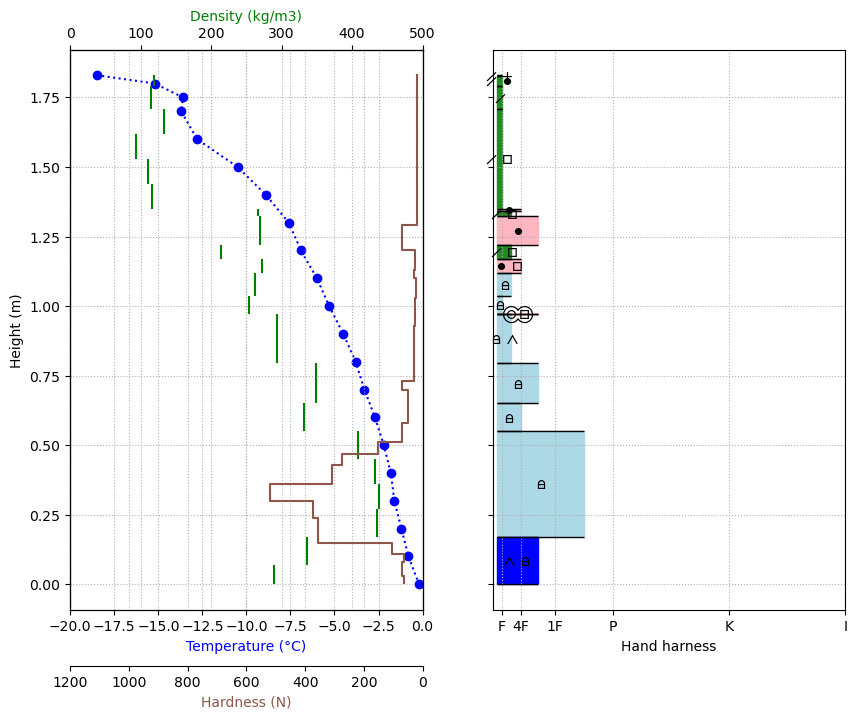

✓ Simple plot created


In [11]:
# Create a simple plot of your snow profile
# This shows the stratigraphy and available profiles

spplot.plot_simple(sp)
plt.show()
print("✓ Simple plot created")

### Custom Stratigraphy Plot

You can also create custom plots using the plotting utilities. Here's an example of a custom stratigraphy plot:


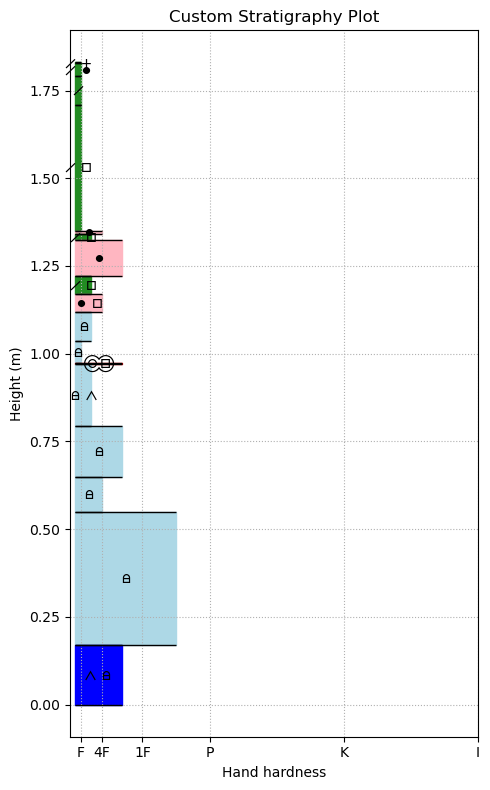

✓ Custom stratigraphy plot created


In [14]:
# Create a custom stratigraphy plot
# This gives you more control over the appearance

if sp.stratigraphy_profile is not None:
    from snowprofile.plot import plot_utils
    
    fig, ax = plt.subplots(figsize=(5, 8))
    
    # Customize the stratigraphy plot
    plot_utils.plot_strati_profile(
        ax, 
        sp.stratigraphy_profile,
        xlabel="Hand hardness",
        ylabel="Height (m)",
        grain_labels=True,      # Show grain type labels
        use_hardness=True       # Use hand hardness for coloring
    )
    
    plt.title("Custom Stratigraphy Plot")
    plt.tight_layout()
    plt.show()
    print("✓ Custom stratigraphy plot created")
else:
    print("No stratigraphy data available for custom plot")


## Tutorial Complete!

You've learned how to:
- Load a CAAML file into a SnowProfile object
- Explore the data (time, location, layers, profiles)
- Analyze temperature gradients
- Create visualizations

**To use your own file**: Change `CAAML_PATH` in Step 4 to point to your CAAML file.

**To modify the analysis**: Edit the code cells above. Each cell has comments explaining what it does and where you can make changes.

**Learn more**: Check out the [official snowprofile documentation](https://snowprofile.readthedocs.io/en/latest/) for advanced features like:
- Reading profiles from CSV files
- Merging multiple profiles
- Creating custom plots
- Working with other data formats
